In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../")

from global_config import config
import seaborn as sns

results_dir           = config.get_property('results_dir')
results2_dir          = config.get_property('results2_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')

feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")
COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

In [2]:
sys.path.insert(0, "../metapop")

from utils_data_metapop import create_population_data, create_time_transfers

path_to_ward_counts = os.path.join(data_db_dir, "long_files_8_25_2021", "counts_ward.csv" )
path_to_ward_transf = os.path.join(data_db_dir, "long_files_8_25_2021", "transfers_ward.csv" )

A_df, D_df, H_df, tests_df, Hmean_df = create_population_data(path_to_ward_counts)

num_wards  = len(Hmean_df)
ward_names = list(Hmean_df.index)
M_df       = create_time_transfers(path_to_ward_transf, num_wards=num_wards, ward_names=ward_names)


In [3]:
from building2title import selected_buildings, building2title

building2id        = {selected_buildings[i]: i for i in range(len(selected_buildings))}
building2id[5]     = "Rest"

def building2building(building):
    if building in selected_buildings:
        return building
    else:
        return "Rest"

counts_ward_df             = pd.read_csv(path_to_ward_counts, parse_dates=["date"])
counts_ward_df["building"] = counts_ward_df.apply(lambda x: x.ward.split("-")[1], axis=1)
counts_ward_df["building"] = counts_ward_df.apply(lambda x: building2building(x.building), axis=1)
counts_ward_df             = counts_ward_df.reset_index(drop=True)
buildings_df               = counts_ward_df.copy(); buildings_df = buildings_df.groupby(['date', 'building']).sum().reset_index()

date_start    = pd.to_datetime('2020-02-01')
date_end      = pd.to_datetime('2021-02-28')
dates         = pd.date_range(date_start, date_end)
Tdat          =  len(dates)

buildings_df  = buildings_df[buildings_df.date.isin(dates)]

A     = pd.pivot(buildings_df, index='building', columns='date', values='num_admitted')
D     = pd.pivot(buildings_df, index='building', columns='date', values='num_discharged')
H     = pd.pivot(buildings_df, index='building', columns='date', values='num_hospitalized')
tests = pd.pivot(buildings_df, index='building', columns='date', values='num_tested')

pop            = H.mean(axis=1)
num_pop        = len(pop)
building_names = pop.index


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_44517/2399673785.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  buildings_df               = counts_ward_df.copy(); buildings_df = buildings_df.groupby(['date', 'building']).sum().reset_index()


In [4]:
buildings_df["building2"] = buildings_df.apply(lambda x: building2building(x.building), axis=1)
buildings_plt_df          = buildings_df.groupby(['date', 'building2']).sum().reset_index()
hosp_df                   = buildings_plt_df.groupby(['date']).sum().reset_index()


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_44517/2188095908.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  buildings_plt_df          = buildings_df.groupby(['date', 'building2']).sum().reset_index()
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_44517/2188095908.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hosp_df                   = buildings_plt_df.groupby(['date']).sum().reset_index()


In [79]:
counts_ward_df["ward_name"] = counts_ward_df["ward"].map(lambda x: x.split("-")[0])
counts_ward_df

wards_initals = list(np.unique([w.split(" ")[0] for w in counts_ward_df.ward_name.unique()]))
# ['Aln', 'Avn', 'Cuimc', 'Eye', 'Hip', 'Hrk', 'Hrt', 'Man', 'Mil', 'Mil/hc', 'Msch', 'Neu', 'Nj', 'Org', 'Pby', 'Rkl', 'Vc', 'Vcl', 'Wch', 'Zzmil', 'Zzmsch']

ward_initial2building = {"Pby": "Presbyterian Hospital",
                            "Aln": "Allen Hospital",
                            "Hip": "Rest",
                            "Hrt": "Rest",
                            "Hrk": "Harkness Pavilion",
                            "Mil": "Milstein Hospital",
                            "Eye": "Rest",
                            "Avn": "Rest",
                            "Msch": "Mschony",
                            "Zzmsch": "Mschony",
                            "Hrk": "Harkness Pavilion",
                            'Hrk': 'Harkness Pavilion',
                            "Vc": "Rest"}

selected_buildings = ['Allen Hospital', 'Harkness Pavilion', 'Milstein Hospital', 'Mschony', 'Presbyterian Hospital', "Rest"]

def correct_building(ward_name):
    ward_building            = ward_name.split("-")[0]

    if ward_building.split(" ")[0] == "Pby":
        return ward_name.split("-")[1]
    try:
        building_coded_intitial = ward_initial2building[ward_building.split(" ")[0]]

        return building_coded_intitial
    except:
        return ward_name.split("-")[1]



In [96]:
counts_ward_df["building2"] = counts_ward_df.apply(lambda x: correct_building(x.ward), axis=1)
counts_ward_df["building2"] = counts_ward_df.apply(lambda x: x.building if x.building=="Rest" else x.building2, axis=1)

H_ward_df               = pd.pivot(counts_ward_df, index='ward', columns='date', values='num_hospitalized')
pop_ward                = np.clip(np.ceil(H_ward_df.mean(axis=1)), 1, None)
pop_ward_df             = pd.DataFrame(pop_ward, columns=["ward_size"]).reset_index()
pop_ward_df["building"] = pop_ward_df["ward"].apply(lambda x: x.split("-")[1])
pop_ward_df["building"] = pop_ward_df["building"].map(lambda x: building2building(x))


ward2warsize = pop_ward_df.set_index("ward").to_dict()["ward_size"]
counts_ward_df["ward_size"] = counts_ward_df["ward"].map(lambda x: ward2warsize[x])
pop_ward2_df = counts_ward_df[["ward", "ward_name", "building",	"building2", "ward_size"]].drop_duplicates().sort_values("ward_size", ascending=False).reset_index(drop=True)


def check_correct_ward(row):
    if row.building == row.building2:
        return True
    return False

pop_ward2_df["correct"] = pop_ward2_df.apply(lambda x: check_correct_ward(x), axis=1)


def keep_row(row):

    if row != 1:
        return True


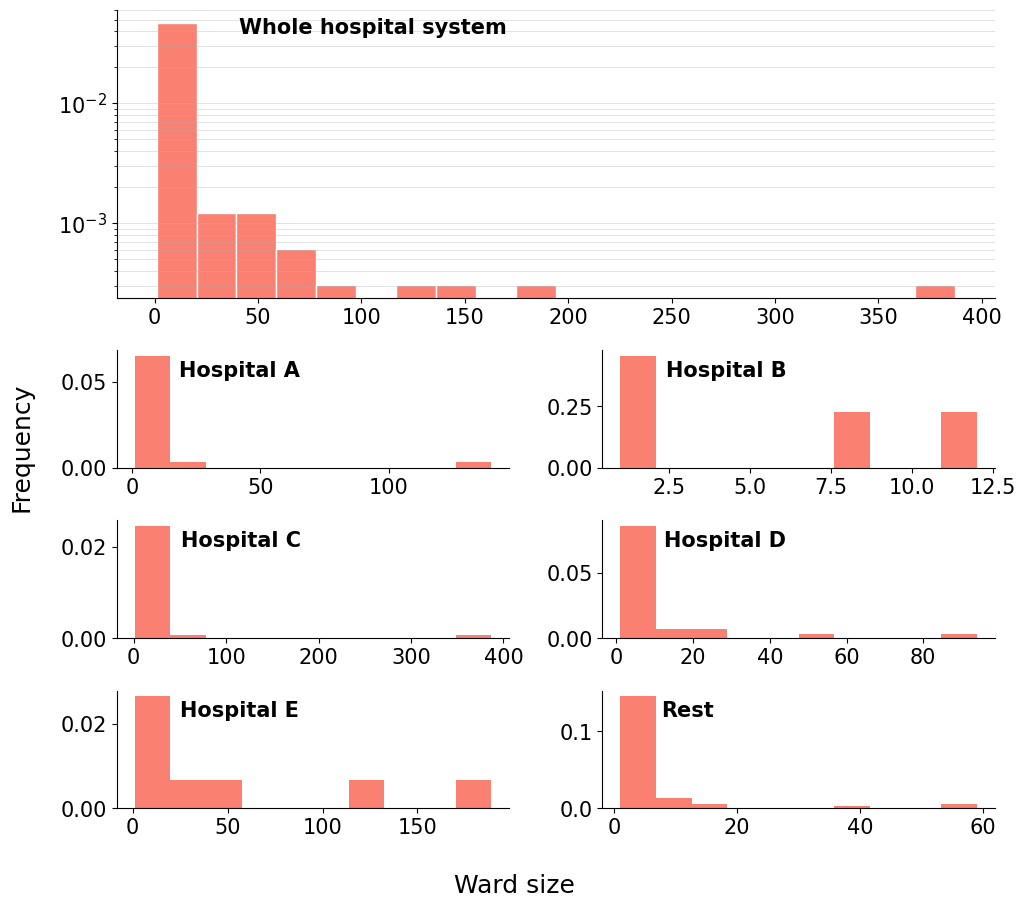

In [115]:
from matplotlib import dates as mdates
from utils_local import plot_utils
import matplotlib.pyplot as plt


from scipy.stats import powerlaw
from scipy.stats import expon

pop_ward_plot_df = pop_ward2_df[pop_ward2_df.correct==True]

layout = [["hospital", "hospital"],
          ["hospital", "hospital"],
          [selected_buildings[0], selected_buildings[1]],
          [selected_buildings[2], selected_buildings[3]],
          [selected_buildings[4], selected_buildings[5]]]

fig, axes = plt.subplot_mosaic(layout,
                                figsize=(10.5, 9.2),
                                sharex=False, sharey=False)

ax = axes["hospital"]

ax.hist(pop_ward_plot_df[pop_ward_plot_df.ward_size >= 1].ward_size.values,
                bins=20, edgecolor="w", facecolor="salmon", density=True, align="mid")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.grid(which="both", axis="y", lw=0.5, alpha=0.5)
ax.text(x              = ax.get_xlim()[1] / 10,
            y          = ax.get_ylim()[1] - ax.get_ylim()[1]/4.5,
            s          = "Whole hospital system",
            fontweight = "bold")

ax.set_yscale("log")

for building in selected_buildings:

    axi         = axes[building]
    ward_sizes  = pop_ward_plot_df[pop_ward_plot_df.building==building].ward_size.values
    x           = np.arange(1, ward_sizes.max()+1)
    count, bins = np.histogram(ward_sizes, bins = x, range = (ward_sizes.min(), ward_sizes.max()+1))

    axi.hist(pop_ward_plot_df.query(f"building=='{building}' and ward_size>0").ward_size.values,
             facecolor="salmon", density=True, align="mid")

    if building == "Harkness Pavilion":
        xpos = 2.4
    else:
        xpos = axi.get_xlim()[1] / 8

    axi.text(x             = xpos,
                y          = axi.get_ylim()[1] - axi.get_ylim()[1]/4.5,
                s          = building2title[building],
                fontweight = "bold")

    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)

fig.supxlabel(r'Ward size')
fig.supylabel(r'Frequency')
plt.tight_layout()

fig.savefig(os.path.join(results2_dir, "paper_figures", "si_figures_corrected", "WardSizeDistribution_figS2.png"),
                                                                                        dpi         = 300,
                                                                                        transparent = True,
                                                                                        bbox_inches = 'tight')


In [117]:
pop_ward_plot_df.to_csv(os.path.join(results2_dir, "paper_figures", "wards_use_corrected.csv"))